<a class="anchor" id=top></a>
## Sections

* [Functions](#1)
* [Load in the dataset](#2)
### Preprocessing
* [General formatting & typecasting](#3)
* [Missing data](#4)
* [Investigate numeric features](#5)
* [Encoding nominal features](#6)
* [Impute missing data (Interest Rate as discrete)](#7)
* [Impute missing data (Interest Rate as continuous)](#8)
### Predict response
* [Logistic Regression](#9)
* [Support Vector Machine](#10)
* [Random Forest](#11)
* [K-Modes](#12)


In [1]:
%matplotlib inline
import io
import matplotlib as mpl
import matplotlib.pyplot as plt
import missingno
import numpy as np
import os
import pandas as pd
import requests
import seaborn as sns
import sklearn.datasets
from IPython.display import Image
from kmodes.kmodes import KModes
from sklearn import metrics, svm
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import normalize, StandardScaler

import warnings
warnings.filterwarnings('ignore')

<a class="anchor" id=1></a>
### Functions  
[Top](#top)

In [2]:
def enum_cols(df):
    cols = df.columns.tolist()
    for idx, col in enumerate(cols):
        print(idx, col)

In [3]:
def tabulate_df(df):
    pad1 = 0
    pad2 = 0
    for col in df.columns:
        if (len(df[col].name) + 2 > pad1):
            pad1 = len(df[col].name) + 2
        if (len(str(df[col].dtype)) + len(str(df[col][0])) + 2 > pad2):
            pad2 = len(str(df[col].dtype)) + len(str(df[col][0])) + 2
    for col in df.columns:
        row_pad1 = pad1
        row_pad2 = pad2
        row_pad1 -= len(df[col].name)
        row_pad2 -= len(str(df[col].dtype)) + len(str(df[col][0]))
        print(f"%s%s%s%s%s" % (df[col].name, "|" + '-'*row_pad1, df[col].dtype, '-'*row_pad2 + "|", df[col][0]))

In [4]:
def min_max_normalize(lst):
  minimum = min(lst)
  maximum = max(lst)
  normalized = []
  
  for i in range(len(lst)):
    normalized.append((lst[i] - minimum) / (maximum - minimum))
    
  return normalized

In [5]:
def plot_categories(df, col):
    ylim = ((max(df[col].value_counts()) * 1.2 + 100) // 100) * 100
    pct_null = {}
    num_null = {}
    for div in df[col].value_counts():
        div_pct = round(div / df[col].value_counts().sum() * 100, 2)

        if (div_pct < 10):
            div_pct = ''
            div_num = ''
        else:
            div_pct = str(div_pct) + "%"
            div_num = div

        pct_null[div] = div_pct
        num_null[div] = div


    f, ax = plt.subplots(figsize=(12, 4)) 

    plt.bar(df[col].value_counts().index, df[col].value_counts().values)
    plt.title("Category Distribution: " + col)
    plt.xlabel("Category")
    plt.ylabel("Count")
    plt.ylim([0, ylim])
    plt.xticks(rotation="vertical")

    rects = ax.patches
    labels = [f"%s" % (pct_null[div]) for div in pct_null]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
                ha='center', va='bottom')
    rects = ax.patches
    labels = [f"%d" % (key) for key in pct_null.keys() if pct_null[key] != '']
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + (ylim * 0.1), label,
                ha='center', va='bottom')

    plt.show();

In [6]:
def plot_matrix(expected, predicted):

    data = metrics.confusion_matrix(expected, predicted, labels=np.unique(expected))
    conf_df = pd.DataFrame(data, columns=np.unique(expected), index=np.unique(expected))
    conf_df.index.name = "Actual"
    conf_df.columns.name = "Predicted"
    
    plt.figure(figsize = (10,7))
    sns_plot = sns.heatmap(conf_df, cmap="Blues", annot=True)
    fig = sns_plot.get_figure()
    fig.savefig("output.png")
    
    Image(filename="output.png")

In [7]:
def evaluate_clf(clf, data, labels):
    # get train_test_split results to train the models
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.20)
    clf.fit(X_train, y_train)

    # output single-pass acc score
    predicted = clf.predict(X_test)
    accuracy = round(accuracy_score(y_test, predicted), 4)*100
    print(f"Single-pass Accuracy: %.2f%s" % (accuracy, "%"))

    # output LOO acc score
    acc_scores = []
    for i in range (2,data.shape[0]//10):
        X_train = data[:i]
        X_test = data[i:]
        y_train = labels[:i]
        y_test = labels[i:]
        clf.fit(X_train, y_train)
        predicted = clf.predict(X_test)
        acc_scores.append(round(accuracy_score(y_test, predicted), 4)*100)
    print(f"Leave-One-Out Accuracy: %.2f%s" % (np.mean(acc_scores), "%"))

    # output stratified k-fold acc score
    accu_scores = []
    reca_scores = []
    prec_scores = []
    k_folds = StratifiedKFold(n_splits=10, shuffle=True)
    for train_i, test_i in k_folds.split(data, labels):
        clf.fit(data[train_i], labels[train_i])
        predicted = clf.predict(data[test_i])
        accu_scores.append(round(accuracy_score(labels[test_i], predicted), 4)*100)
        reca_scores.append(round(recall_score(labels[test_i], predicted, average="weighted"), 4)*100)
        prec_scores.append(round(precision_score(labels[test_i], predicted, average="weighted"), 4)*100)
    print(f"Stratified 10-Fold Cross Validation Accuracy: %.2f%s" % (np.mean(accu_scores), "%"))

    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.20)
    clf.fit(X_train, y_train)
    expected = y_test
    predicted = clf.predict(X_test)

    # get sorted confidence scores for correct predictions
    df = pd.DataFrame(columns=["Expected", "Predicted", "Confidence"])
    for i in range(len(expected)):
        new_row = pd.Series({"Expected": expected[i], 
                             "Predicted": predicted[i], 
                             "Probability": str(round((max(clf.predict_proba(X_test)[i]))*100, 2)) + "%"})
        df = df.append(new_row, ignore_index=True)
    df.sort_values(by=["Confidence"], ascending=False, inplace=True)
    matches_df = df[df["Expected"] == df["Predicted"]]
    conf_df = matches_df.groupby(["Expected"])["Confidence"].max().sort_values(ascending=False)
    conf_df = conf_df.to_frame().reset_index()

    print("\nMean Classification scores:")
    print(f"Accuracy: %.2f%s" % (np.mean(accu_scores), "%"))
    print(f"Recall: %.2f%s" % (np.mean(reca_scores), "%"))
    print(f"Precision: %.2f%s" % (np.mean(prec_scores), "%"))
    x = range(len(accu_scores))

    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    plt.plot(x, accu_scores)
    plt.plot(x, prec_scores)
    plt.title("Classification Scores by K Folds")
    plt.ylabel("%")
    plt.xlabel("K")
    plt.legend(["Accuracy", "Precision"])
    ax.xaxis.grid(True)
    plt.show();

    plot_matrix(expected, predicted);
    return accu_scores, reca_scores, prec_scores, conf_df

<a class="anchor" id=2></a>
### Load in the dataset 
[Top](#top)

In [8]:
# get and view the raw data

cloud_url = "https://onedrive.live.com/download?cid=0E469DD64885C4A1&resid=E469DD64885C4A1%2131781&authkey=AM9f5rUfRHzxy9c"
url_data = requests.get(cloud_url).content
df = pd.read_csv(io.StringIO(url_data.decode('utf-8')))
print("Shape:", df.shape)
df.head(2)

Shape: (1468, 26)


,Purpose Code,Revised Purpose Code,diff purp code,Collateral Code,Revised Collateral Code,diff coll code,purp/coll diff,Property Type,Net Operating Income,Annual Debt Service,...,Original Balance,Net Current Balance,Unused Commitment,Open Date,Date Maturity,Interest Rate,Guarantor?,Risk Code,Relationship ID,Division
0,98.0,90.0,diff,8602.0,8602.0,match,diff/match,Homebuilder,NaN,NaN,...,"299,265.74",0.00,"299,265.74",03/03/10,12/31/79,4.75%,YES,4,5436,Lancaster Division
1,98.0,98.0,match,8409.0,8409.0,match,match/match,Other,NaN,NaN,...,"26,592.80",0.00,"26,592.80",08/22/12,12/31/79,5.25%,no,5,9388,Lancaster Division


In [9]:
# Risk Code has many categories and no correlation to the target variable

df["Risk Code"].replace("W", 0, inplace=True)
df["Risk Code"] = df["Risk Code"].astype("float64")
df["Risk Code"].value_counts()

5.0    741
4.0    582
6.0     62
0.0     33
3.0     22
7.0     21
2.0      6
Name: Risk Code, dtype: int64

In [10]:
# check data types and (to a lesser extent) null landscape

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1468 entries, 0 to 1467
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Purpose Code                  1464 non-null   float64
 1   Revised Purpose Code          1465 non-null   float64
 2   diff purp code                1467 non-null   object 
 3   Collateral Code               1427 non-null   float64
 4   Revised Collateral Code       1466 non-null   float64
 5   diff coll code                1467 non-null   object 
 6   purp/coll diff                1467 non-null   object 
 7   Property Type                 1467 non-null   object 
 8   Net Operating Income          0 non-null      float64
 9   Annual Debt Service           0 non-null      float64
 10  Appraised Value               0 non-null      float64
 11  SWAP?                         0 non-null      float64
 12  State                         1467 non-null   object 
 13  Ban

In [11]:
len(df["Revised Collateral Code"].unique())

41

## Preprocessing

<a class="anchor" id=3></a>
### General formatting & typecasting
[Top](#top)

In [12]:
# fix excess whitespace in column names

cols = df.columns.tolist()
df.columns = [" ".join(col.split()) for col in cols]
enum_cols(df)

0 Purpose Code
1 Revised Purpose Code
2 diff purp code
3 Collateral Code
4 Revised Collateral Code
5 diff coll code
6 purp/coll diff
7 Property Type
8 Net Operating Income
9 Annual Debt Service
10 Appraised Value
11 SWAP?
12 State
13 Bank
14 Team
15 Region
16 Original Balance
17 Net Current Balance
18 Unused Commitment
19 Open Date
20 Date Maturity
21 Interest Rate
22 Guarantor?
23 Risk Code
24 Relationship ID
25 Division


In [13]:
# drop fully-null, no-correlation, and datetime columns

df.drop(["Purpose Code", 
         "Revised Purpose Code", 
         "purp/coll diff", 
         "Net Operating Income", 
         "Annual Debt Service", 
         "Appraised Value", 
         "SWAP?",
         "Open Date", 
         "Date Maturity", 
         "Risk Code", 
         "Relationship ID"
        ], 
        axis=1, inplace=True)

In [14]:
# investigate appropriate data type for each column

tabulate_df(df)

diff purp code|-----------object----------------|diff
Collateral Code|----------float64-------------|8602.0
Revised Collateral Code|--float64-------------|8602.0
diff coll code|-----------object---------------|match
Property Type|------------object---------|Homebuilder
State|--------------------object------------------|PA
Bank|---------------------object------------------|FB
Team|---------------------object--------------|MOWERY
Region|-------------------object-----------------|CPA
Original Balance|---------object---------|299,265.74 
Net Current Balance|------object---------------|0.00 
Unused Commitment|--------object---------|299,265.74 
Interest Rate|------------object---------------|4.75%
Guarantor?|---------------object-----------------|YES
Division|-----------------object--|Lancaster Division


Observations from this view:
* typecast numeric features
* clean whitespace on data elements

In [15]:
df[df.columns[9:13]].head(2)

,Original Balance,Net Current Balance,Unused Commitment,Interest Rate
0,"299,265.74",0.00,"299,265.74",4.75%
1,"26,592.80",0.00,"26,592.80",5.25%


In [16]:
# cast relevant columns to dtype needed

# typecast as object
cols = ["Collateral Code", 
        "Revised Collateral Code"]
for col in cols:
    df[col] = df[col].astype(object)
    
# typecast as float64
cols = ["Original Balance", 
        "Net Current Balance", 
        "Unused Commitment"]
for col in cols:
    df[col] = df[col].str.strip() # clean whitespace on data elements
    df[col].replace(to_replace=r',', value=r'', inplace=True, regex=True)
    df[col] = df[col].astype("float64")
df["Interest Rate"].replace(to_replace=r'%', value=r'', inplace=True, regex=True)
df["Interest Rate"] = df["Interest Rate"].astype("float64")
df["Interest Rate"] = df["Interest Rate"].divide(100, fill_value=np.nan)

numeric_cols = ["Original Balance",
                "Net Current Balance",
                "Unused Commitment", 
                "Interest Rate"]

Categorical columns are of datatype 'object', which is crucial for effective encoding for imputation of missing data.

See: https://towardsdatascience.com/preprocessing-encode-and-knn-impute-all-categorical-features-fast-b05f50b4dfaa

In [17]:
# columns now typecast appropriately
# whitespace for column names and data now clean

tabulate_df(df)

diff purp code|-----------object----------------|diff
Collateral Code|----------object--------------|8602.0
Revised Collateral Code|--object--------------|8602.0
diff coll code|-----------object---------------|match
Property Type|------------object---------|Homebuilder
State|--------------------object------------------|PA
Bank|---------------------object------------------|FB
Team|---------------------object--------------|MOWERY
Region|-------------------object-----------------|CPA
Original Balance|---------float64----------|299265.74
Net Current Balance|------float64----------------|0.0
Unused Commitment|--------float64----------|299265.74
Interest Rate|------------float64-------------|0.0475
Guarantor?|---------------object-----------------|YES
Division|-----------------object--|Lancaster Division


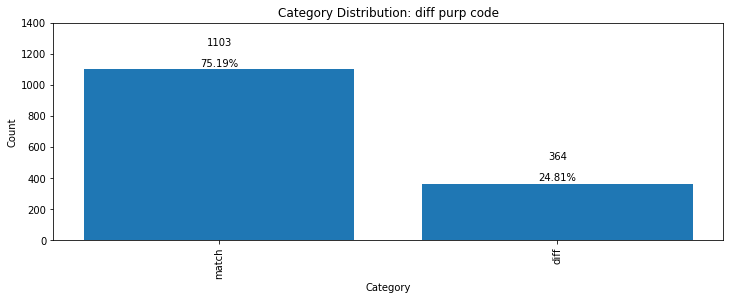

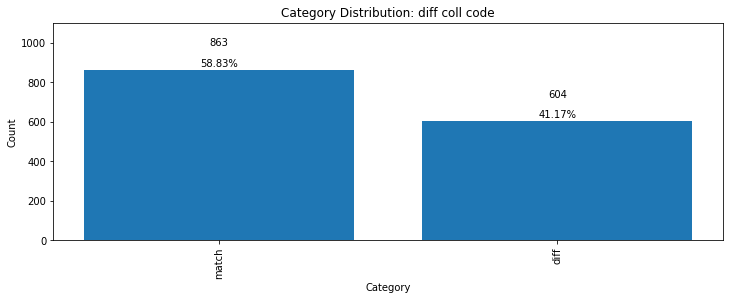

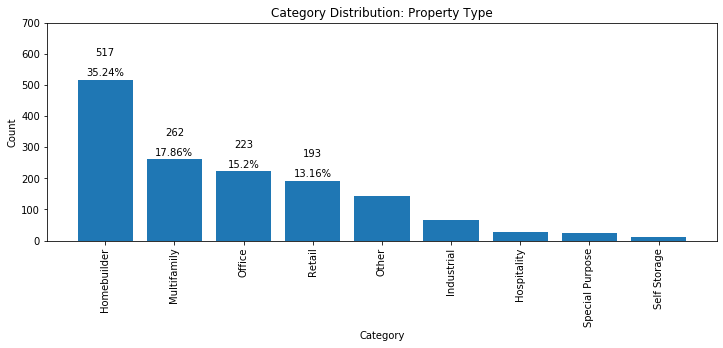

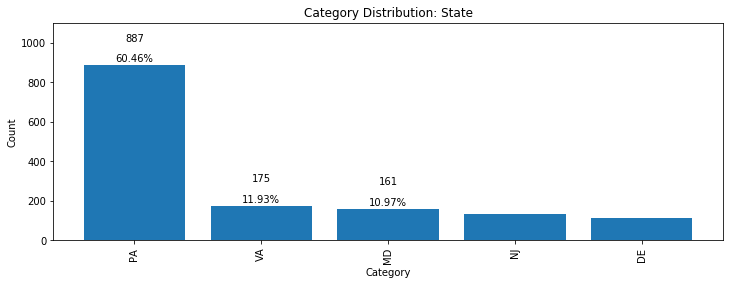

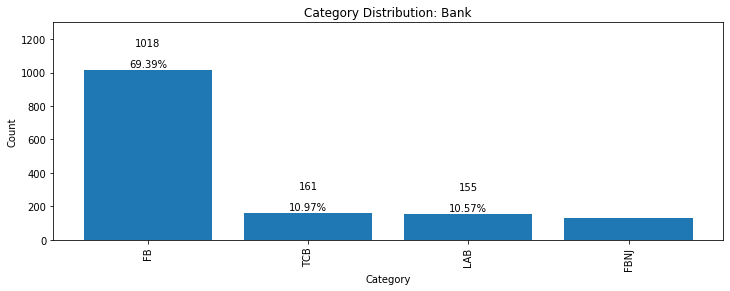

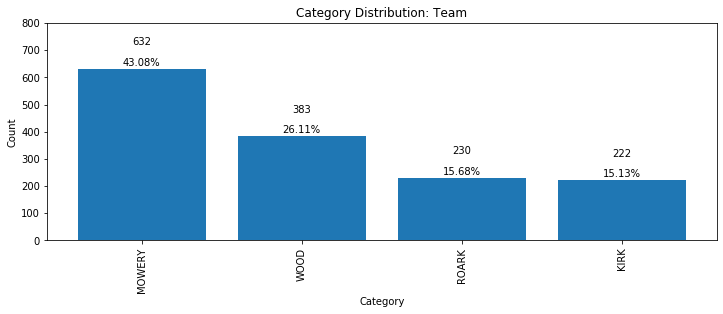

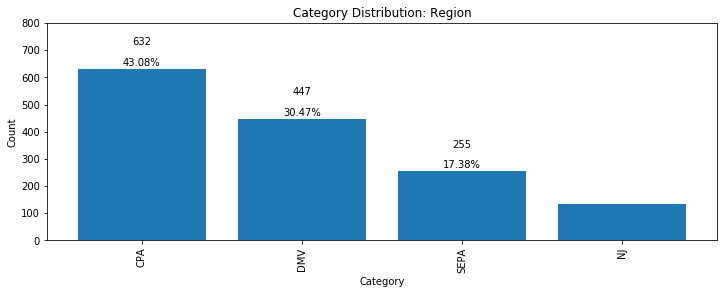

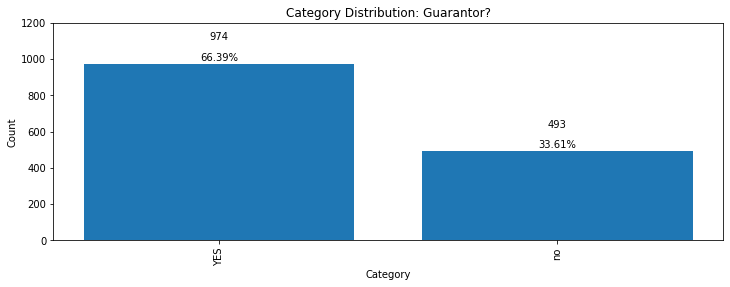

In [18]:
# generate histograms for nominal features

for col in df.columns:
    if (df[col].dtype == np.object and col not in ["Collateral Code", "Revised Collateral Code", "Division"]):
        plot_categories(df, col)

For Purpose Codes and Collateral Codes, we also note that 75% and 58% were not revised, respectively.

In [19]:
# move target variable ["Revised Collateral Code"] to the end of the dataframe

cols = df.columns.tolist()
print(f"Moving column: <%s> to the end." % cols[2])

cols = cols[:2] + cols[3:] + cols[2:3]
df = df[cols]
df.head(2)

Moving column: <Revised Collateral Code> to the end.


,diff purp code,Collateral Code,diff coll code,Property Type,State,Bank,Team,Region,Original Balance,Net Current Balance,Unused Commitment,Interest Rate,Guarantor?,Division,Revised Collateral Code
0,diff,8602,match,Homebuilder,PA,FB,MOWERY,CPA,299265.74,0.0,299265.74,0.0475,YES,Lancaster Division,8602
1,match,8409,match,Other,PA,FB,MOWERY,CPA,26592.80,0.0,26592.80,0.0525,no,Lancaster Division,8409


<a class="anchor" id=4></a>
### Missing data
[Top](#top)

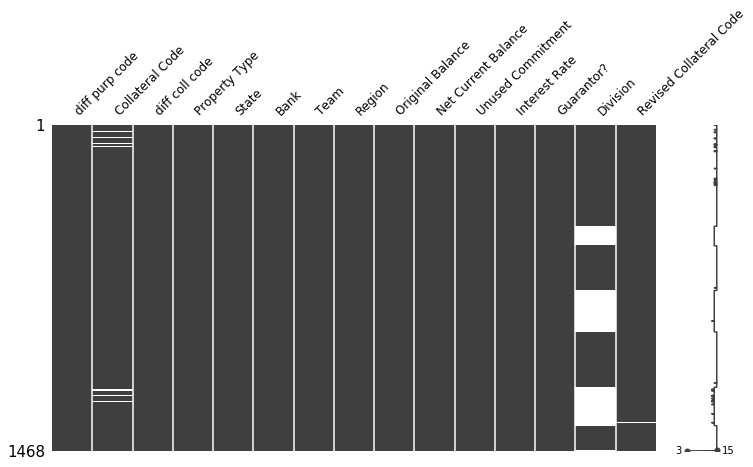

In [20]:
# visualize locations of remaining missing data

missingno.matrix(df, figsize=(12,6), fontsize=12);

Note: The sparkline on the right summarizes the general shape of the data completeness and points out rows with the maximum and minimum nullity in the dataset.

In [21]:
# check target variable for missing data

df[df["Revised Collateral Code"].isnull()]

,diff purp code,Collateral Code,diff coll code,Property Type,State,Bank,Team,Region,Original Balance,Net Current Balance,Unused Commitment,Interest Rate,Guarantor?,Division,Revised Collateral Code
1340,diff,3300,diff,Other,DE,FB,ROARK,DMV,1.950000e+05,1.497673e+05,0.000000e+00,0.0385,YES,NaN,NaN
1467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.975708e+09,1.765887e+09,7.770930e+08,NaN,NaN,NaN,NaN


In [22]:
# row 1340 had its Collateral Code deleted without revision
# row 1467 is mostly null, an anomoly we may ignore

df.drop(df[df["Revised Collateral Code"].isnull()].index, 
        axis=0, inplace=True)

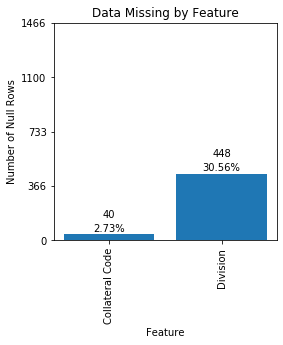

In [23]:
# visualize percent of data missing per impacted column

pct_null = {}
for col in df.columns:
    if (round(df[col].isnull().sum()/len(df[col])*100, 2) > 0):
        pct_null[col] = round(df[col].isnull().sum()/len(df[col])*100, 2)

num_null = {}
for col in df.columns:
    if (df[col].isnull().sum() > 0):
        num_null[col] = df[col].isnull().sum()
        
f, ax = plt.subplots(figsize=(4, 4)) 

plt.bar(num_null.keys(), num_null.values(), zorder=2)
plt.title("Data Missing by Feature")
plt.xlabel("Feature")
plt.ylabel("Number of Null Rows")
plt.ylim(0, 100)
plt.yticks([0, len(df)*0.25, len(df)*0.50, len(df)*0.75, len(df)])
plt.xticks(rotation="vertical")

# Generate bar labels
rects = ax.patches
labels = [f"%.2f%s" % (pct_null[col], "%") for col in pct_null]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
    
rects = ax.patches
labels = [f"%d" % (num_null[col]) for col in num_null]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 100, label,
            ha='center', va='bottom')
    
plt.show();

In [24]:
# for columns with less than 6% null, simply drop the offending rows.

df.dropna(subset=["Collateral Code"], inplace=True)
print(f"%.2f%s sacrificed by dropping null rows from least-impacted columns." % ((1466 - df.shape[0]) / 1466 * 100, "%"))

2.73% sacrificed by dropping null rows from least-impacted columns.


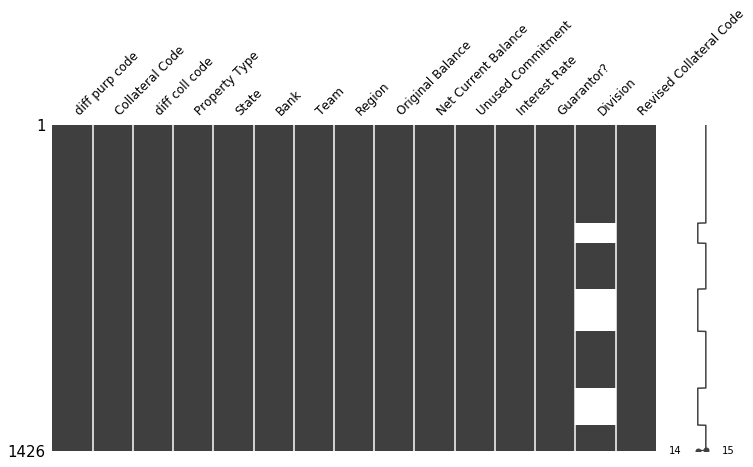

In [25]:
# visualize locations of remaining missing data

missingno.matrix(df, figsize=(12,6), fontsize=12);

The remaining missing data is found in feature Division (30% null). Classification algorithms would benefit from having as much data as possible to learn from, so I will prefer imputation over exlusion of these observations.

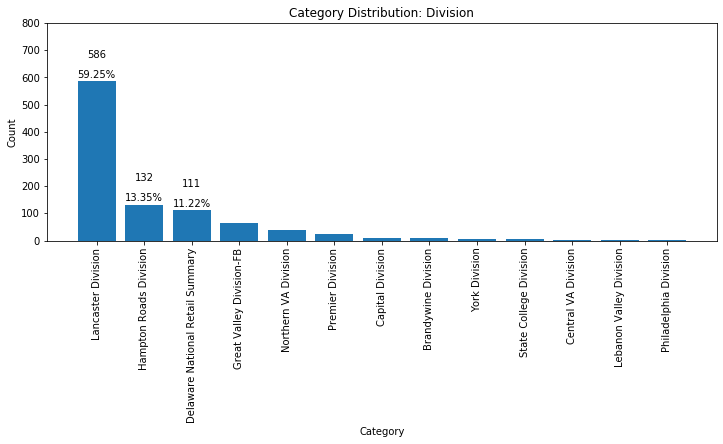

In [26]:
# Plot the distribution of categories within ["Division"]

plot_categories(df, "Division")

Before I can fill this column with predicted data from a classifier, I'll have to encode these categories (KNN can only work with integers, for example). Also of note is the imbalance in proportion of categories represented in Division, a proportion we'll want to preserve in randomly sampled subsets. 

<a class="anchor" id=5></a>
### Investigate numeric features
[Top](#top)

In [27]:
# examine outliers in numeric columns

test_df = df.copy()
for col in test_df[numeric_cols].columns:
    test_df.drop(test_df[test_df[col].between(test_df[col].quantile(.15), test_df[col].quantile(.85))].index, inplace=True) # without outliers
test_df[numeric_cols].head(2)

,Original Balance,Net Current Balance,Unused Commitment,Interest Rate
1047,11175000.0,8723990.39,1875000.00,0.0415
1313,11440500.0,10520093.92,920406.08,0.0480


These all appear to be real dollar amounts, and not sentinels. I will not remove them from the dataset.

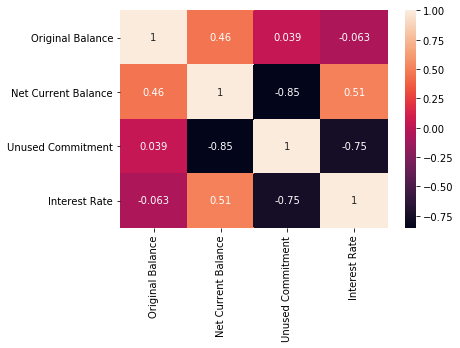

In [28]:
sns.heatmap(test_df[numeric_cols].corr(), annot=True);

Some collinearity is noted between Unused Commitment and Net Current Balance.

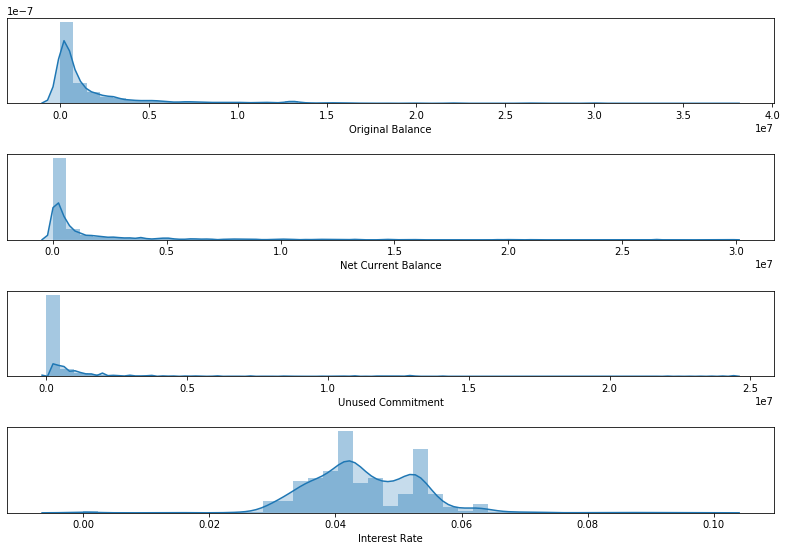

In [29]:
# generate density plots of raw numeric features

fig, axs = plt.subplots(4, 1, figsize=(12, 8))
fig.tight_layout(pad=3.0)
for i, col in enumerate(df[numeric_cols]):
    axs[i].tick_params( axis='y', which='both', left=False, right=False, labelleft=False) 
    sns.distplot(df[col], ax=axs[i], kde_kws={"shade": True})

Original Balance, Net Current Balance, and Unused Commitment are severely right-skewed, and will benefit from a log transformation.

Interest Rate is noted as moderately bimodal. Classification algorithms may perform best with this data represented as binary (at the cost of some data loss). I will run models under each representation and compare results.

[top](#top)

In [30]:
for col in df[numeric_cols]:
    if (col != "Interest Rate"):
        df[col] = np.log1p(df[col])

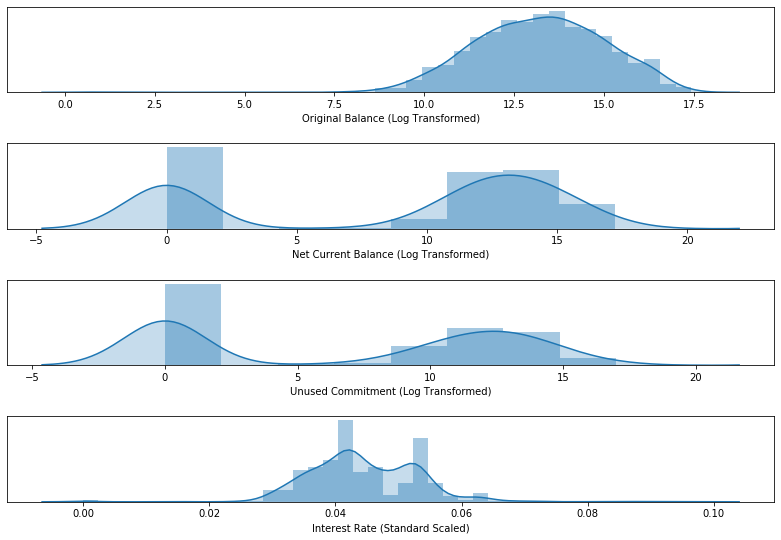

In [31]:
labels = [" (Log Transformed)", 
          " (Log Transformed)", 
          " (Log Transformed)", 
          " (Standard Scaled)"]
fig, axs = plt.subplots(4, 1, figsize=(12, 8))
fig.tight_layout(pad=3.0)

for i, col in enumerate(df[numeric_cols]):
    axs[i].tick_params( axis='y', which='both', left=False, right=False, labelleft=False) 
    sns.distplot(df[col], ax=axs[i], kde_kws={"shade": True}, axlabel=col + labels[i])

Two columns appear to have a bimodal distribution. I may want to create binary columns that fit rows to the appropriate group for each, and remove the original columns from analysis to avoid collinearity.

In [32]:
df[df["Original Balance"] < 7.5]

,diff purp code,Collateral Code,diff coll code,Property Type,State,Bank,Team,Region,Original Balance,Net Current Balance,Unused Commitment,Interest Rate,Guarantor?,Division,Revised Collateral Code
394,match,8604,match,Homebuilder,PA,LAB,KIRK,SEPA,0.693147,0.0,0.693147,0.05,YES,Lancaster Division,8604


In [33]:
# removing one low-end outlier for Original Balance

df.drop(394, inplace=True)

In [34]:
# address bimodal Interest Rate with a label for each apparent group

df["Interest Rate hi/lo"] = ["high" if cell > 0.0475 else "low" for cell in df["Interest Rate"]]

For simplicity, we'll consider "Net Current Balance" and "Unused Commitment" binary, since they are clearly bimodal.

In [35]:
# create boolean columns for ["Net Current Balance"] and ["Unused Commitment"]

df["has_Net_Current_Balance"] = ((df["Net Current Balance"] != 0) * 1).astype("uint8")
df["has_Unused_Commitment"] = ((df["Unused Commitment"] != 0) * 1).astype("uint8")

# remove original columns from the dataset

df.drop(["Net Current Balance", "Unused Commitment"], axis=1, inplace=True)

Next, scale the remaining numeric columns to strengthen our models' predictive power.

In [36]:
scaler = StandardScaler()
df[["Original Balance", "Interest Rate"]] = scaler.fit_transform(df[["Original Balance", "Interest Rate"]])
df[["Original Balance", "Interest Rate"]].head(2)

,Original Balance,Interest Rate
0,-0.358853,0.339309
1,-1.740378,0.907521


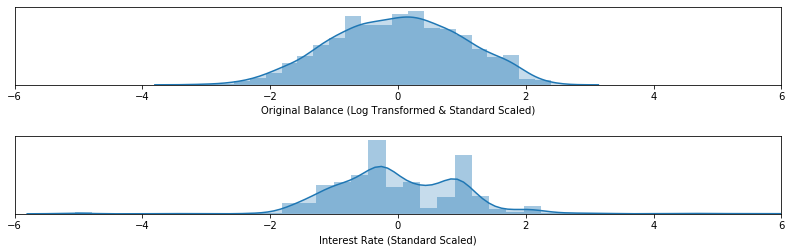

In [37]:
# plot transformed and scaled numeric columns

cols = ["Original Balance", "Interest Rate"]
labels = [" (Log Transformed & Standard Scaled)",
          " (Standard Scaled)"]
fig, axs = plt.subplots(2, 1, figsize=(12, 4))
fig.tight_layout(pad=3.0)

for i, col in enumerate(df[cols]):
    axs[i].tick_params( axis='y', which='both', left=False, right=False, labelleft=False)
    sns.distplot(df[col], ax=axs[i], kde_kws={"shade": True}, axlabel=col + labels[i])
    axs[i].set_xlim(-6, 6)

In [38]:
cols = df.columns.tolist()
print(f"Moving columns: <%s> to their original positions." % cols[14:])


df = df[cols[:9] + cols[14:] + cols[13:14] + cols[9:13]]

Moving columns: <['has_Net_Current_Balance', 'has_Unused_Commitment']> to their original positions.


In [39]:
df.head(2)

,diff purp code,Collateral Code,diff coll code,Property Type,State,Bank,Team,Region,Original Balance,has_Net_Current_Balance,has_Unused_Commitment,Interest Rate hi/lo,Interest Rate,Guarantor?,Division,Revised Collateral Code
0,diff,8602,match,Homebuilder,PA,FB,MOWERY,CPA,-0.358853,0,1,low,0.339309,YES,Lancaster Division,8602
1,match,8409,match,Other,PA,FB,MOWERY,CPA,-1.740378,0,1,high,0.907521,no,Lancaster Division,8409


In [40]:
target = df["Revised Collateral Code"].astype("int64").astype(str)
target[0]

'8602'

In [41]:
# update 'numeric_cols' so we can still distinguish between nominal and numeric

numeric_cols = df.select_dtypes(["float64", "uint8"]).columns

In [42]:
unencoded_df = df.copy()

<a class="anchor" id=6></a>
### Encoding nominal features
[Top](#top)

In [43]:
df_to_encode = df.copy()
drop_cols = df_to_encode.select_dtypes(["float64", "uint8"]).columns

df_to_encode.drop(drop_cols, axis=1, inplace=True)
df_to_encode.drop(["Division", "Revised Collateral Code"], axis=1, inplace=True)

In [44]:
# df_to_encode.head(2)

In [45]:
# count how many dimensions will be added by one-hot-encoding each nominal column

print("Number of factors per feature:")
for col in df_to_encode.columns:
    print(df_to_encode[col].nunique(), col)

Number of factors per feature:
2 diff purp code
54 Collateral Code
2 diff coll code
9 Property Type
5 State
4 Bank
4 Team
4 Region
2 Interest Rate hi/lo
2 Guarantor?


#### Perform the encoding

In [46]:
# One-Hot encode these columns

df_to_encode = pd.get_dummies(df_to_encode)

In [47]:
# append numeric columns to encoded dataframe

encoded_df = df_to_encode.merge(df[drop_cols], left_index=True, right_index=True)
encoded_df = encoded_df.merge(df["Division"], left_index=True, right_index=True)

In [48]:
print(encoded_df.shape)
encoded_df.head(2)

(1425, 93)


,diff purp code_diff,diff purp code_match,Collateral Code_1.0,Collateral Code_2.0,Collateral Code_1200.0,Collateral Code_3100.0,Collateral Code_3300.0,Collateral Code_3800.0,Collateral Code_4100.0,Collateral Code_5100.0,...,Region_SEPA,Interest Rate hi/lo_high,Interest Rate hi/lo_low,Guarantor?_YES,Guarantor?_no,Original Balance,has_Net_Current_Balance,has_Unused_Commitment,Interest Rate,Division
0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,-0.358853,0,1,0.339309,Lancaster Division
1,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,-1.740378,0,1,0.907521,Lancaster Division


<a class="anchor" id=7></a>
### Fill missing data (Interest Rate as discrete)
[Top](#top)

In [49]:
# drop the continuous version of Interest Rate

df_to_split = encoded_df.drop(["Interest Rate"], axis=1)

#### Split into training and testing sets

In [50]:
# split data into a non-null subset

train_df = df_to_split[df_to_split["Division"].notnull()]
test_df = df_to_split[df_to_split["Division"].isnull()]
test_df.drop(["Division"], axis=1, inplace=True)

data = train_df[train_df.columns.difference(["Division"])].values # X
labels = train_df["Division"].values.ravel() # y

In [51]:
# get train_test_split results to train the models

X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state=42)

#### K-Nearest Neighbors

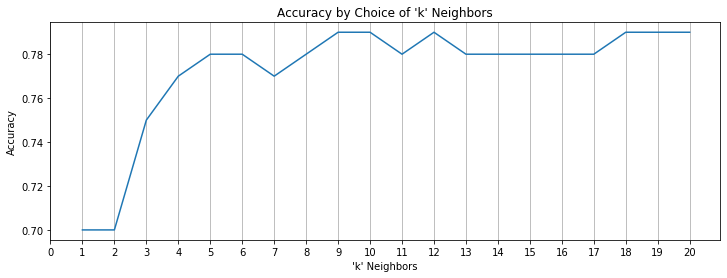

In [52]:
x = []
y = []
for k in range(1, 21):
    clf = KNN(n_neighbors=k, weights='distance')
    clf.fit(X_train, y_train) # (DataFrame, list)
    score = clf.score(X_test, y_test) # (DataFrame, list)
    x.append(k)
    y.append(round(score, 2))
    
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(x, y)
plt.title("Accuracy by Choice of 'k' Neighbors")
plt.ylabel("Accuracy")
plt.xlabel("'k' Neighbors")
plt.xticks([x for x in range(0, 21)])
ax.xaxis.grid(True)
plt.show();

In [53]:
k = 9
clf = KNN(n_neighbors=k, weights='distance')
clf.fit(X_train, y_train) # (DataFrame, list)
score = clf.score(X_test, y_test) # (DataFrame, list)
print(f"Optimal K: %d\nAccuracy: %.2f%s" % (k, score*100, "%"))

Optimal K: 9
Accuracy: 78.54%


Classification report: 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='distance'):

                                  precision    recall  f1-score   support

             Brandywine Division       0.00      0.00      0.00         0
             Central VA Division       0.00      0.00      0.00         1
Delaware National Retail Summary       0.96      0.87      0.92        31
        Great Valley Division-FB       0.33      0.30      0.32        10
          Hampton Roads Division       0.79      0.66      0.72        41
              Lancaster Division       0.82      0.90      0.86       145
            Northern VA Division       0.33      0.18      0.24        11
                Premier Division       0.50      0.50      0.50         8
          State College Division       0.00      0.00      0.00         0

                        accuracy            

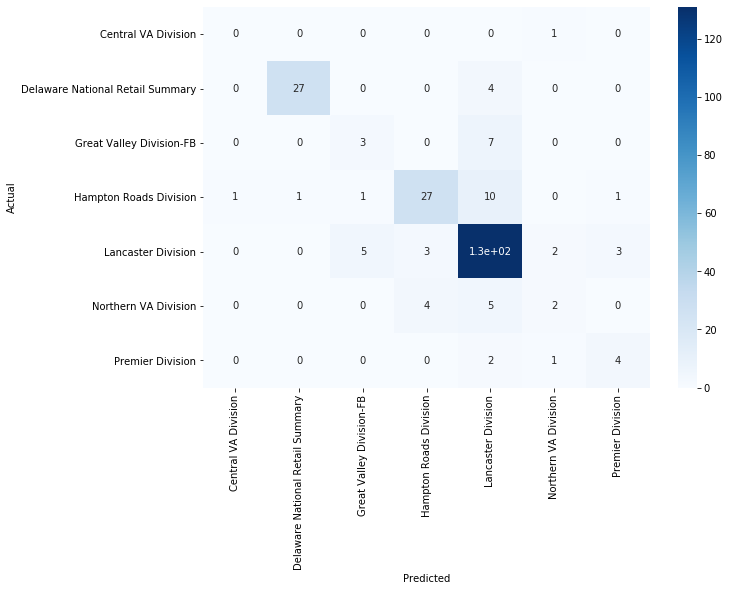

In [54]:
expected = y_test
predicted = clf.predict(X_test)

print("Classification report: \n%s:\n\n%s\n"
      % (clf, metrics.classification_report(expected, predicted)))

plot_matrix(expected, predicted);

Harmonic mean of precision and recall, F1 score = $2\frac{precision.recall}{precision+recall}$
F score attempts to find a balance between precision and recall.

In [55]:
# fill column of missing categories with their predicted data

test_df["Division"] = clf.predict(test_df)

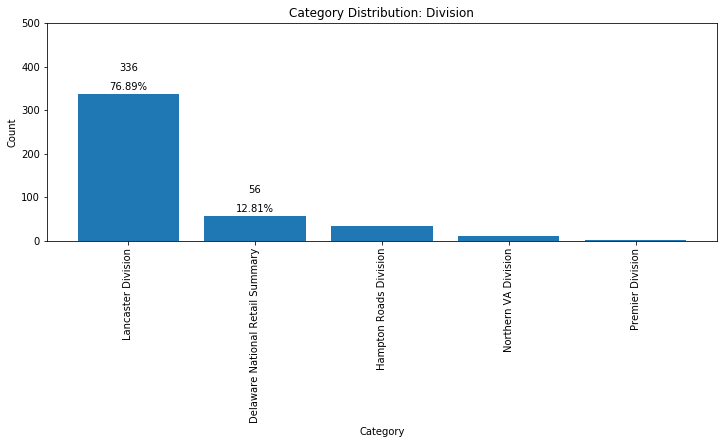

In [56]:
plot_categories(test_df, "Division")

Distribution of predicted labels closely matches the distribution of known labels, indicating that our classifier is operating on meaningful patterns identified in the dataset.

In [57]:
y_pred = clf.predict(X_test)
score = balanced_accuracy_score(y_test, y_pred, adjusted=True)
print(f"Balanced accuracy score of a dummy classifier: %.2f%s" % (score * 100, "%"))

Balanced accuracy score of a dummy classifier: 40.25%


In [58]:
# drop rows with missing data

df_to_split.drop(df_to_split[df_to_split["Division"].isnull()].index, inplace=True)

In [59]:
# and append rows with predicted data added

df = df_to_split.append(test_df)

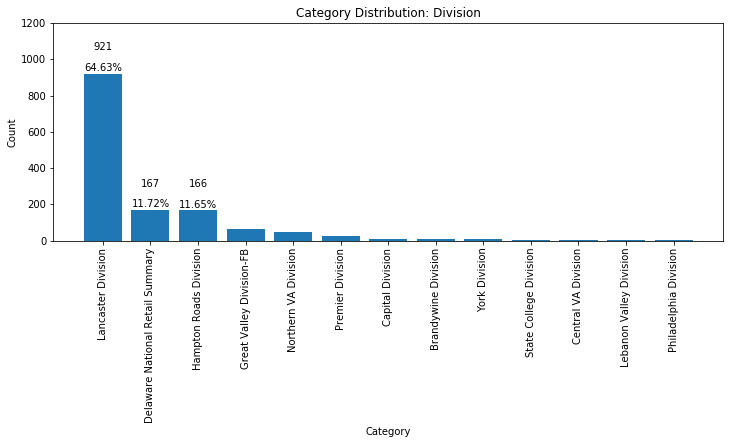

In [60]:
plot_categories(df, "Division")

In [61]:
df_discrete = df.drop(["Original Balance"], axis=1)

In [62]:
df_discrete.head(2)

,diff purp code_diff,diff purp code_match,Collateral Code_1.0,Collateral Code_2.0,Collateral Code_1200.0,Collateral Code_3100.0,Collateral Code_3300.0,Collateral Code_3800.0,Collateral Code_4100.0,Collateral Code_5100.0,...,Region_DMV,Region_NJ,Region_SEPA,Interest Rate hi/lo_high,Interest Rate hi/lo_low,Guarantor?_YES,Guarantor?_no,has_Net_Current_Balance,has_Unused_Commitment,Division
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,1,Lancaster Division
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,Lancaster Division


<a class="anchor" id=8></a>
### Fill missing data (Interest Rate as continuous)
[Top](#top)

In [63]:
# drop the discrete version of Interest Rate

df_to_split = encoded_df.drop(["Interest Rate hi/lo_high", "Interest Rate hi/lo_low"], axis=1)

#### Split into training and testing sets

In [64]:
# split data into a non-null subset

train_df = df_to_split[df_to_split["Division"].notnull()]
test_df = df_to_split[df_to_split["Division"].isnull()]
test_df.drop(["Division"], axis=1, inplace=True)

data = train_df[train_df.columns.difference(["Division"])].values # X
labels = train_df["Division"].values.ravel() # y

In [65]:
# get train_test_split results to train the models

X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state=42)

#### K-Nearest Neighbors

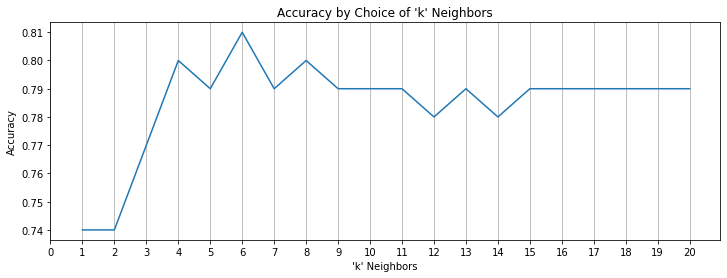

In [66]:
x = []
y = []
for k in range(1, 21):
    clf = KNN(n_neighbors=k, weights='distance')
    clf.fit(X_train, y_train) # (DataFrame, list)
    score = clf.score(X_test, y_test) # (DataFrame, list)
    x.append(k)
    y.append(round(score, 2))
    
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(x, y)
plt.title("Accuracy by Choice of 'k' Neighbors")
plt.ylabel("Accuracy")
plt.xlabel("'k' Neighbors")
plt.xticks([x for x in range(0, 21)])
ax.xaxis.grid(True)
plt.show();

In [67]:
k = 6
clf = KNN(n_neighbors=k, weights='distance')
clf.fit(X_train, y_train) # (DataFrame, list)
score = clf.score(X_test, y_test) # (DataFrame, list)
print(f"Optimal K: %d\nAccuracy: %.2f%s" % (k, score*100, "%"))

Optimal K: 6
Accuracy: 80.57%


Classification report: 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='distance'):

                                  precision    recall  f1-score   support

             Brandywine Division       0.00      0.00      0.00         0
             Central VA Division       0.00      0.00      0.00         1
Delaware National Retail Summary       0.96      0.87      0.92        31
        Great Valley Division-FB       0.55      0.60      0.57        10
          Hampton Roads Division       0.75      0.66      0.70        41
              Lancaster Division       0.84      0.91      0.87       145
            Northern VA Division       0.50      0.27      0.35        11
                Premier Division       0.57      0.50      0.53         8

                        accuracy                           0.81       247
                       macro avg       0.52 

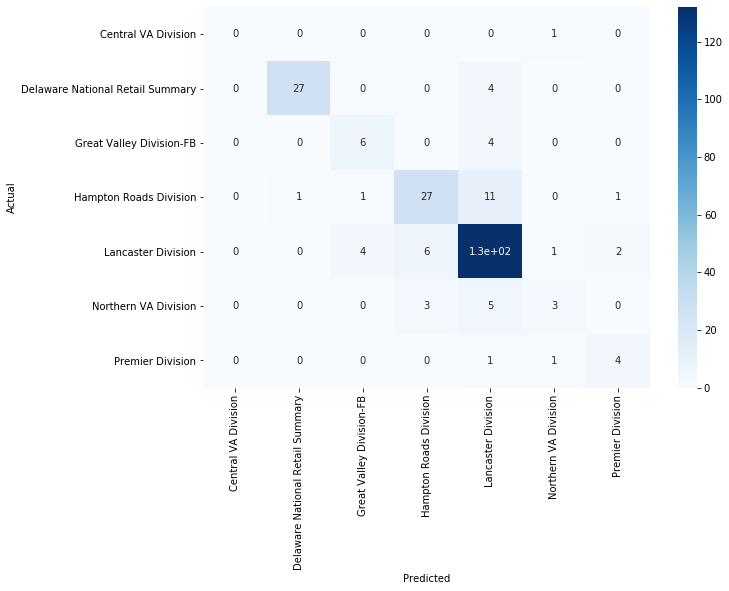

In [68]:
expected = y_test
predicted = clf.predict(X_test)

print("Classification report: \n%s:\n\n%s\n"
      % (clf, metrics.classification_report(expected, predicted)))

plot_matrix(expected, predicted)

In [69]:
# fill column of missing categories with their predicted data

test_df["Division"] = clf.predict(test_df)

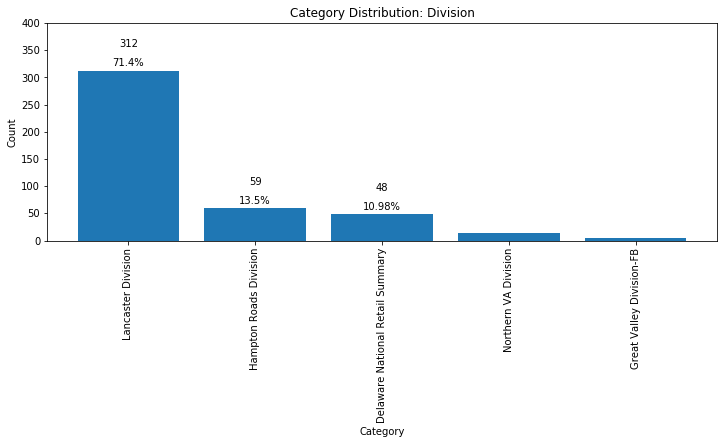

In [70]:
plot_categories(test_df, "Division")

Proportions of predicted labels closely matches the proportions of ground truth labels, indicating that our classifier is operating on meaningful patterns identified in the dataset.

In [71]:
y_pred = clf.predict(X_test)
score = balanced_accuracy_score(y_test, y_pred, adjusted=True)
print(f"Balanced accuracy score of a dummy classifier: %.2f%s" % (score * 100, "%"))

Balanced accuracy score of a dummy classifier: 46.88%


Compute the balanced accuracy

The balanced accuracy in binary and multiclass classification problems deal with imbalanced datasets. It is defined as the average of recall obtained on each class.

The best value is 1 and the worst value is 0 when adjusted=False.

Treating Interest Rate as continuous seems like a better fit, giving us better average recall and accuracy of predicted categories.

In [72]:
# drop rows with missing data

df_to_split.drop(df_to_split[df_to_split["Division"].isnull()].index, inplace=True)

In [73]:
# and append rows with predicted data added

df = df_to_split.append(test_df)

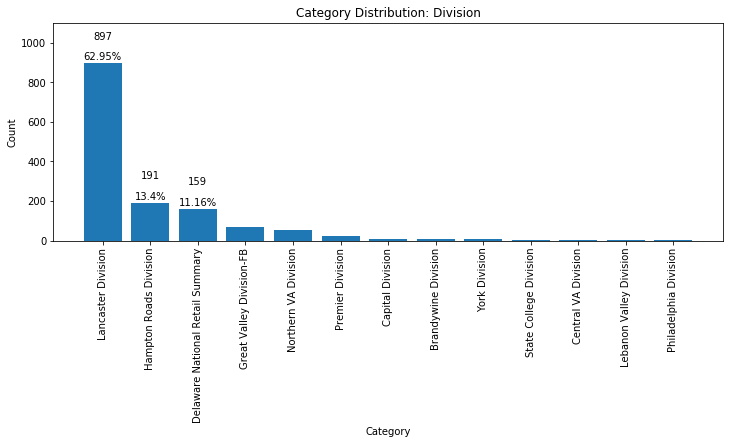

In [74]:
plot_categories(df, "Division")

We've now filled Division with predicted categories, while maintaining the proportions of each category from the original known data.

In [75]:
df2 = df.copy()
dummies = pd.get_dummies(df2["Division"])

In [76]:
df2.drop(["Division"], axis=1, inplace=True)
data = df2.merge(dummies, left_index=True, right_index=True)

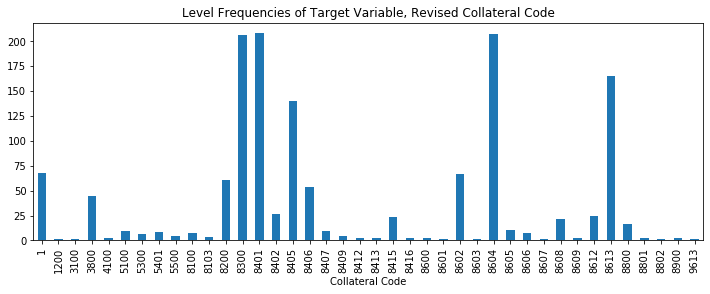

In [77]:
# plot distribution of target variable

df_value_counts = pd.DataFrame(target.value_counts())
df_value_counts.sort_index(inplace=True)

fig, ax = plt.subplots(figsize=(12, 4))
ax.set_title("Level Frequencies of Target Variable, Revised Collateral Code")
plt.xlabel("Collateral Code")
df_value_counts.plot(ax=ax, kind='bar', legend=False);

In [78]:
data = data.values # X
labels = target.values.ravel() # y

In [79]:
df.head()

,diff purp code_diff,diff purp code_match,Collateral Code_1.0,Collateral Code_2.0,Collateral Code_1200.0,Collateral Code_3100.0,Collateral Code_3300.0,Collateral Code_3800.0,Collateral Code_4100.0,Collateral Code_5100.0,...,Region_DMV,Region_NJ,Region_SEPA,Guarantor?_YES,Guarantor?_no,Original Balance,has_Net_Current_Balance,has_Unused_Commitment,Interest Rate,Division
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,-0.358853,0,1,0.339309,Lancaster Division
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,-1.740378,0,1,0.907521,Lancaster Division
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,-0.392271,0,1,0.907521,Lancaster Division
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,-1.097108,0,1,0.907521,Lancaster Division
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,-0.814796,0,1,3.123551,Lancaster Division


Final dataset, ready for predictive modelling.
* 'data' (X)
* 'labels' (y)

## Predict response

<a class="anchor" id=9></a>
### Logistic Regression
[Top](#top)

from: https://chrisalbon.com/machine_learning/naive_bayes/multinomial_logistic_regression/

Logistic Regression output

Single-pass Accuracy: 41.40%
Leave-One-Out Accuracy: 15.81%
Stratified 10-Fold Cross Validation Accuracy: 41.06%

Mean Classification scores:
Accuracy: 41.06%
Recall: 41.06%
Precision: 37.03%


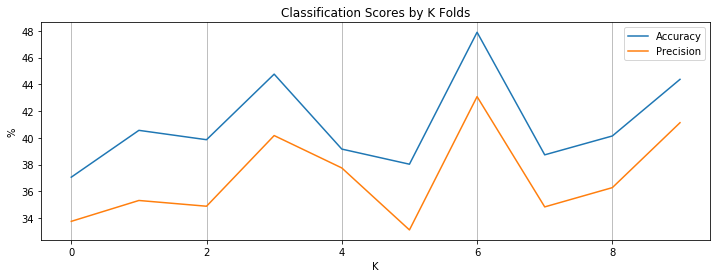

,Expected,Confidence
0,1,NaN
1,8200,NaN
2,8300,NaN
3,8401,NaN
4,8402,NaN


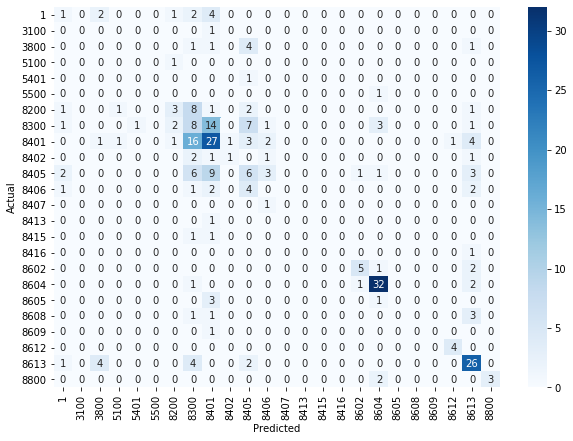

In [80]:
clf = LogisticRegression(multi_class='multinomial', solver='newton-cg')

print("Logistic Regression output\n")
lr_accu, lr_reca, lr_prec, lr_conf_df = evaluate_clf(clf, data, labels)
lr_conf_df.head()

<a class="anchor" id=10></a>
### Support Vector Machine
[Top](#top)

Support Vector Machine output

Single-pass Accuracy: 22.11%
Leave-One-Out Accuracy: 12.11%
Stratified 10-Fold Cross Validation Accuracy: 25.19%

Mean Classification scores:
Accuracy: 25.19%
Recall: 25.19%
Precision: 11.26%


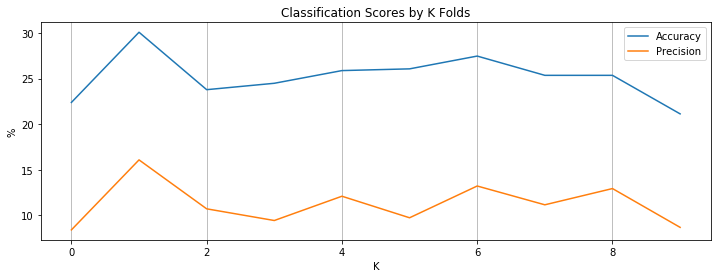

,Expected,Confidence
0,8300,NaN
1,8401,NaN
2,8604,NaN


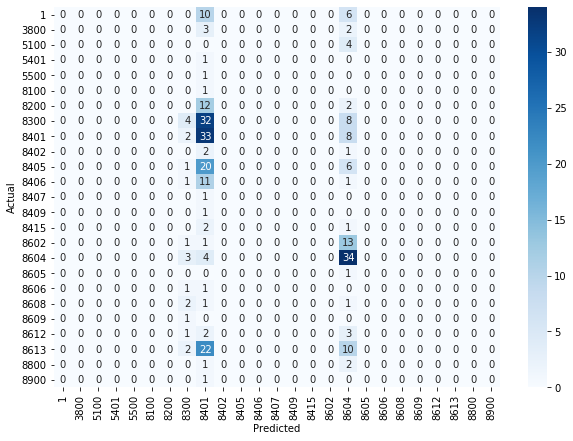

In [81]:
clf = svm.SVC(gamma=0.001, probability=True)

print("Support Vector Machine output\n")
svm_accu, svm_reca, svm_prec, svm_conf_df = evaluate_clf(clf, data, labels)
svm_conf_df.head()

<a class="anchor" id=11></a>
### Random Forest
[Top](#top)

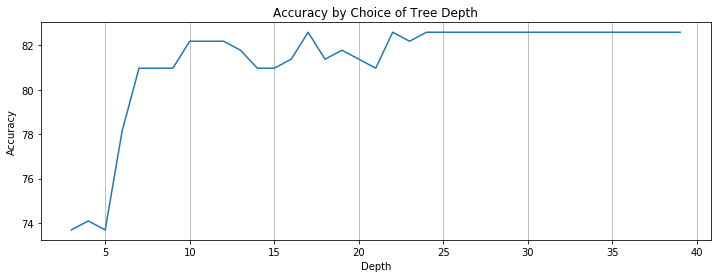

In [82]:
x = []
y = []
for i in range(3, 40):
    clf = RF(n_jobs=2, n_estimators=200, max_depth=i, random_state=42)
    clf.fit(X_train, y_train) # (DataFrame, list)
    score = clf.score(X_test, y_test) # (DataFrame, list)
    x.append(i)
    y.append(score*100)
    
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(x, y)
plt.title("Accuracy by Choice of Tree Depth")
plt.ylabel("Accuracy")
plt.xlabel("Depth")
ax.xaxis.grid(True)
plt.show();

Random Forest output

Single-pass Accuracy: 41.05%
Leave-One-Out Accuracy: 17.16%
Stratified 10-Fold Cross Validation Accuracy: 47.58%

Mean Classification scores:
Accuracy: 47.58%
Recall: 47.58%
Precision: 44.29%


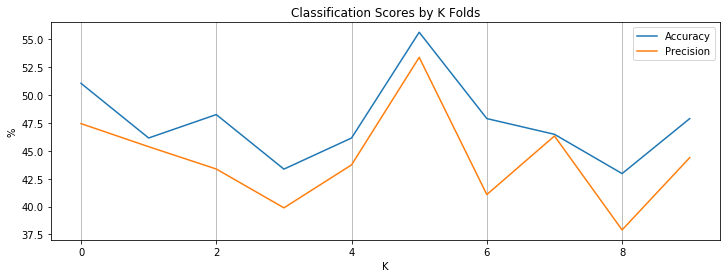

,Expected,Confidence
0,1,NaN
1,8200,NaN
2,8300,NaN
3,8401,NaN
4,8405,NaN


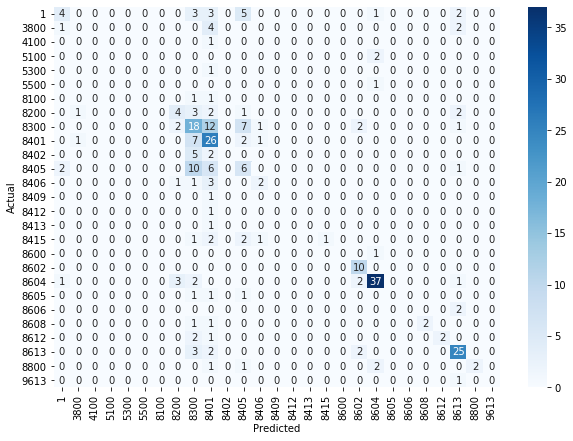

In [83]:
clf = RF(n_jobs=2, n_estimators=200, max_depth=10, random_state=42)

print("Random Forest output\n")
rf_accu, rf_reca, rf_prec, rf_conf_df = evaluate_clf(clf, data, labels)
rf_conf_df.head()

In [84]:
clfs = ["Logistic Regression", "SVM", "Random Forest"]
stats = ["Accuracy", "Precision"]
data = [[lr_accu, lr_prec], [svm_accu, svm_prec], [rf_accu, rf_prec]]
ddf = pd.DataFrame(columns=["Percent", "Classifier", " "])

for c in range(len(clfs)):
    for s in range(len(stats)):
        lr = pd.DataFrame(data[c][s], columns=["Percent"])
        lr["classifier"] = clfs[c]
        lr[" "] = stats[s]
        ddf = ddf.append(lr, ignore_index=True)

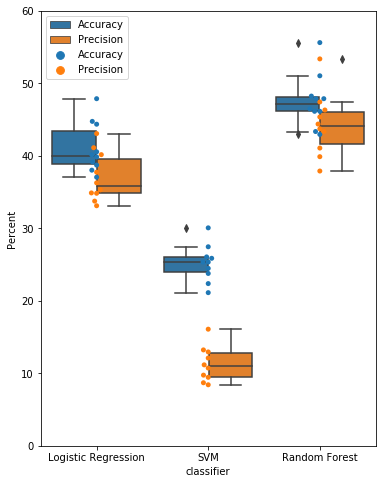

In [85]:
fig = plt.figure(figsize=(6, 8))
ax = sns.boxplot(x="classifier", 
            y="Percent", 
            hue=" ", 
            data=ddf)
ax.set_ylim([0, 60])
ax = sns.swarmplot(x="classifier", 
            y="Percent", 
            hue=" ", 
            data=ddf)
ax.legend(loc="upper left")

<a class="anchor" id=12></a>
### K-Modes
[Top](#top)

In [86]:
df2 = df_discrete.copy()
dummies = pd.get_dummies(df2["Division"])

In [87]:
df2.drop(["Division"], axis=1, inplace=True)
data = df2.merge(dummies, left_index=True, right_index=True)

In [88]:
cost = 99999
for i in range(2, 30):
    clf = KModes(n_clusters=i, init='Huang', n_init=10, verbose=0)
    clusters = clf.fit_predict(data)
    
    if clf.cost_ < cost:
        cost = clf.cost_
        centroid = clf.cluster_centroids_
        shape = centroid.shape[0]
        
print(f"Lowest cost: %d" % (cost))
print(f"Clusters identified: %d" % (shape))
for i in range(shape):
    if sum(centroid[i,:]) == 0:
        print(f"\nCluster: %s" % (str(i + 1)))
        print("empty cluster")
    else:
        print(f"\nCluster: %s" % (str(i + 1)))
        for j in data.columns[np.nonzero(centroid[i,:])]:
            print(j)

Lowest cost: 5170
Clusters identified: 29

Cluster: 1
diff purp code_diff
diff coll code_match
State_PA
Bank_FB
Team_MOWERY
Region_CPA
Interest Rate hi/lo_low
Guarantor?_YES
has_Net_Current_Balance
Lancaster Division

Cluster: 2
diff purp code_match
diff coll code_match
State_PA
Bank_FB
Team_MOWERY
Region_CPA
Interest Rate hi/lo_low
Guarantor?_YES
has_Unused_Commitment
Lancaster Division

Cluster: 3
diff purp code_match
diff coll code_match
State_PA
Bank_LAB
Team_KIRK
Region_SEPA
Interest Rate hi/lo_low
Guarantor?_YES
has_Net_Current_Balance
Lancaster Division

Cluster: 4
diff purp code_match
diff coll code_diff
Property Type_Homebuilder
State_DE
Bank_FB
Team_WOOD
Region_DMV
Interest Rate hi/lo_high
Guarantor?_YES
has_Unused_Commitment
Lancaster Division

Cluster: 5
diff purp code_match
diff coll code_match
State_VA
Bank_FB
Team_WOOD
Region_DMV
Interest Rate hi/lo_low
Guarantor?_YES
has_Net_Current_Balance
Lancaster Division

Cluster: 6
diff purp code_diff
diff coll code_diff
State_MD
